<a href="https://colab.research.google.com/github/codebecker/generative-adversarial-networks/blob/main/fmnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!mkdir input
!mkdir outputs

mkdir: cannot create directory ‘input’: File exists
mkdir: cannot create directory ‘outputs’: File exists


  0%|          | 0/117 [00:00<?, ?it/s]

mlflow run id:d2546ee34809428188aa744c037fdde5
##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)


118it [01:51,  1.05it/s]                         
  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 0 of 2
Generator loss: 1.54600561, Discriminator loss: 0.91483301


118it [02:10,  1.11s/it]                         


Epoch 1 of 2
Generator loss: 1.98016083, Discriminator loss: 0.78901297
DONE TRAINING


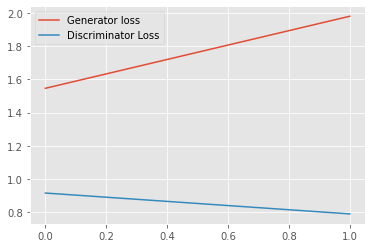

In [12]:
# %%writefile vanilla_gan.py
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
import mlflow
import os
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from models.model_factory import model_factory
from transformations.transform_factory import transform_factory
from loader import loader

matplotlib.style.use('ggplot')

# specify dataset name
ds_name = "fmnist"
# learning parameters
batch_size = 512
epochs = 2
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
model_save_interval = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlflow.end_run()
mlflow.start_run()
mlflow.set_experiment(ds_name)
mlflow_experiment_id = mlflow.get_experiment_by_name(ds_name).experiment_id
mlflow_run_id = mlflow.active_run().info.run_id
log_path = "mlruns/"+str(mlflow_experiment_id)+"/"+str(mlflow_run_id)+"/"+"artifacts"+"/"
mlflow.log_param("run_id", mlflow_run_id)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)
mlflow.log_param("sample_size", sample_size)
mlflow.log_param("nz", nz)
mlflow.log_param("k", k)
mlflow.log_param("device", device)
mlflow.log_param("model_save_interval", model_save_interval)
print("mlflow run id:"+mlflow_run_id)

transform =  transform_factory.transform_factory(ds_name).get_compose()
to_pil_image = transforms.ToPILImage()

train_data = loader(ds_name, transform).getDataset()
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

generator = model_factory.generator_factory(ds_name, nz).to(device)
discriminator = model_factory.discriminator_factory(ds_name).to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')

print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function
criterion = nn.BCELoss() #binary cross entropy

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    #mlflow.keras.log_model(discriminator, "models_history")
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)


    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss    

# create the noise vector
noise = create_noise(sample_size, nz)

generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)

    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, log_path+"gen_img"+str(epoch)+".png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g.cpu().detach().numpy())
    losses_d.append(epoch_loss_d.cpu().detach().numpy())
    
    mlflow.log_metric("loss_generator", losses_g[-1].item())
    mlflow.log_metric("loss_discriminator", losses_d[-1].item())  
    if epoch % model_save_interval == 0: #each model is 60mb in size
        torch.save(generator.state_dict(), log_path+"generator"+str(epoch)+".pth")
        torch.save(discriminator.state_dict(), log_path+"discriminator"+str(epoch)+".pth")

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(log_path+'generator_images.gif', imgs)

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g , label='Generator loss')
plt.plot(losses_d , label='Discriminator Loss')
plt.legend()
plt.savefig(log_path+'loss.png')

In [ ]:
# !python vanilla_gan.py